**Ejercicio Análisis de Datos**

**Escenario**

Ciclystic es una empresa de bicicletas compartidas de Chicago, hasta ahora, la estrategia de marketing de Cyclistic se basaba en la construcción de un reconocimiento de marca general y en atraer a amplios segmentos de consumidores. Uno de los enfoques que ayudó a hacer esto posible fue la flexibilidad de sus planes de precios: pases de un solo viaje, pases de un día completo y membresías anuales. A los clientes que compran pases de un solo viaje o pases de un día completo se los llama ciclistas ocasionales. Los clientes que compran membresías anuales se llaman miembros de Cyclistic.<br>

Los analistas financieros de Cyclistic llegaron a la conclusión de que los miembros anuales son mucho más rentables que los ciclistas ocasionales. Aunque la flexibilidad de precios ayuda a Cyclistic a atraer más clientes, la directora de marketing cree que maximizar el número de miembros anuales será clave para el crecimiento futuro. En lugar de crear una campaña de marketing que apunte a todos los clientes nuevos, la directora cree que hay muchas posibilidades de convertir a los ciclistas ocasionales en miembros. Ella señala que los ciclistas ocasionales ya conocen el programa de Cyclistic y han elegido a Cyclistic para sus necesidades de movilidad.<br>

Para convertir a los ciclistas ocasionales en miembros anuales, el equipo de analistas de marketing necesita entender mejor cómo difieren los miembros anuales y los ciclistas ocasionales, por qué los ciclistas ocasionales comprarían una membresía. La directora y su equipo están interesados en analizar los datos históricos de viajes en bicicleta de Cyclistic para identificar tendencias durante el año 2024.<br>

**Pregunta de negocio**<br> 

¿En qué se diferencian los socios anuales y los ciclistas ocasionales con respecto al uso de las bicicletas de Cyclistic? 

**Preparación de datos**

Se descargaron 12 archivos por cada mes del año 2024, a continuación, se unirán los datos en una base de datos denominada df_total para facilitar el analisis de información. Es importante mencionar que, se comprobó cada una de las variables para que coincida cada base de datos debajo de otra. 

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd

# Configuración
DATASET = "carolinayepes/data-cyclistic" 
DEST_DIR = "data"

def get_kaggle_data(dataset: str, dest_dir: str = "data"):
  
    if os.path.exists(dest_dir) and any(os.scandir(dest_dir)):
        print(f"Los datos ya existen en '{dest_dir}', no se descargaron de nuevo.")
        return

    # Crear carpeta si no existe
    os.makedirs(dest_dir, exist_ok=True)

    # Autenticación con Kaggle
    api = KaggleApi()
    api.authenticate()

    print(f"Descargando dataset {dataset} ...")
    api.dataset_download_files(dataset, path=dest_dir, unzip=True)
    print(f"Dataset descargado y extraído en: {dest_dir}")

# Ejecutar
get_kaggle_data(DATASET, DEST_DIR)

df_total = pd.read_csv("data/data_cyclistic_completo.csv")

✅ Los datos ya existen en 'data', no se descargaron de nuevo.


In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
from shapely.geometry import Point
import folium

**Definición de variables**

El conjunto de datos de la empresa Ciclystic, está compuesto por las siguientes variables:

**ride_id:** Identificación única del viaje.<br>
**rideable_type:** Tipo de bicicleta, eléctica o clásica.<br>	
**started_at:** Fecha y hora del préstamo.<br>	
**ended_at:** Fecha y hora de devolución.<br> 	
**start_station_name:** Nombre de la estación donde se prestó la bicicleta.<br> 	
**start_station_id:** Identificación única de la estación donde se prestó la bicicleta.<br>	
**end_station_name:** Nombre de la estación donde se regresó la bicicleta.<br>	
**end_station_id:** Identificación única de la estación donde se regresó la bicicleta.<br>	
**start_lat:** Latitud de la estación donde se prestó la bicicleta.<br>
**start_lng:** Longitud de la estación donde se prestó la bicicleta.<br>
**end_lat:** Latitud de la estación donde se regresó la bicicleta.<br>	
**end_lng:** Longitud de la estación donde se regresó la bicicleta.<br>
**member_casual:** Determina si el usuario es suscrito o casual.<br>

**Limpieza de datos** 

Se realiza con el propósito de limpiar información sesgada, la cual no es pertinente tomar en el proceso de análisis, ya que, entre más precisa la base de datos, más certeros serán los resultados que se obtendrán. A continuación, es posible observar que en las variables *"start_station_name", "start_station_id" "end_station_name", "end_station_id", "end_lat"* y *"end_lng"*, se encuentra un número significativo de valores nulos (NaN), por lo tanto, se procederá a depurar para que no interfiera con el análisis de datos a priori.

In [9]:
# Consultar cuántos valores nulos se encuentra en las variables:

nulos = df_total.isna().sum()
print(f"Total de valores nulos: {nulos}")

Total de valores nulos: ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1080470
start_station_id      1080470
end_station_name      1111801
end_station_id        1111801
start_lat                   0
start_lng                   0
end_lat                  7340
end_lng                  7340
member_casual               0
dtype: int64


In [ ]:
# Eliminar valores nulos y contar cuántas filas se eliminaron:

filas_antes_nulos = len(df_total)
df_total.dropna(inplace=True)
filas_despues_nulos = len(df_total)
print(f"Se eliminaron: {filas_antes_nulos - filas_despues_nulos} filas con datos nulos.")

# Eliminar valores duplicados y contar cuántas filas se eliminaron:

filas_antes_duplicados = len(df_total)
df_total.duplicated().sum()
filas_despues_duplicados = len(df_total)
print(f"Se eliminaron: {filas_antes_duplicados - filas_despues_duplicados} filas con datos duplicados.")

Se eliminaron: 1652259 filas con datos nulos.
Se eliminaron: 0 filas con datos duplicados.


Luego de la limpieza de datos, se plantearán algunas preguntas con su correspondiente análisis de acuerdo a los resultados obtenidos:

**¿Cuántos viajes se realizaron durante el año 2024?<br>
¿Cuál fue la duración promedio por viaje?**<br>

Adicionalmente, se crearán dos variables llamadas *travel_duration* la cual hace referencia a los minutos que duró cada viaje y la variable *travel_hour* define la hora en que se realizó el viaje, que posteriormente se analizarán.

In [ ]:
# Total de viajes realizados en 2024: 

total_viajes_2024 = len(df_total)
print(f"- El total de viajes en 2024 fue de {total_viajes_2024}.")

# Convertir las columnas de tiempo:

df_total['started_at'] = pd.to_datetime(df_total['started_at'], format='mixed')
df_total['ended_at'] = pd.to_datetime(df_total['ended_at'], format='mixed')

# Calcular la duración de cada viaje en minutos: 

df_total['travel_duration'] = ((df_total['ended_at'] - df_total['started_at']).dt.total_seconds() / 60).round().astype(int)

# Calcular la duración promedio por viaje en minutos:

duracion_promedio_minutos = df_total['travel_duration'].mean().round()
print(f"- La duración promedio por viaje fue de {int(duracion_promedio_minutos)} minutos.")

# Calcular la hora en que se realizó cada viaje:

df_total['travel_hour'] = df_total['started_at'].dt.hour

# Calcular la hora promedio de viaje:

hora_promedio = df_total['travel_hour'].mean().round()
print(f"- La hora promedio por viaje fue a las {int(hora_promedio)} horas.")


df_total

- El total de viajes en 2024 fue de 4208309.
- La duración promedio por viaje fue de 17 minutos.
- La hora promedio por viaje fue a las 14 horas.


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,travel_duration,travel_hour
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27.000,2024-01-12 15:37:59.000,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.903267,-87.634737,41.889177,-87.638506,member,8,15
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46.000,2024-01-08 15:52:59.000,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902937,-87.634440,41.889177,-87.638506,member,7,15
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19.000,2024-01-27 12:35:19.000,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902951,-87.634470,41.889177,-87.638506,member,8,12
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17.000,2024-01-29 16:56:06.000,Wells St & Randolph St,TA1305000030,Larrabee St & Webster Ave,13193,41.884295,-87.633963,41.921822,-87.644140,member,30,16
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23.000,2024-01-31 06:09:35.000,Lincoln Ave & Waveland Ave,13253,Kingsbury St & Kinzie St,KA1503000043,41.948797,-87.675278,41.889177,-87.638506,member,26,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860559,36DAF3C93190E07F,classic_bike,2024-12-13 15:40:06.123,2024-12-13 15:46:29.553,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member,6,15
5860561,71F02C3CF79B8090,classic_bike,2024-12-17 08:09:12.581,2024-12-17 08:15:50.134,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member,7,8
5860562,85AE8840FA0E4EAB,classic_bike,2024-12-18 08:22:40.737,2024-12-18 08:29:25.021,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member,7,8
5860565,15602635C5DF484E,electric_bike,2024-12-31 17:10:03.113,2024-12-31 17:17:21.838,Albany Ave & Bloomingdale Ave,15655,California Ave & Milwaukee Ave,13084,41.914027,-87.705126,41.922695,-87.697153,member,7,17


El total de viajes realizados para el año 2024 fue de **4'208.309**, con una duración promedio de **17** minutos, la variable *travel_hour* será abordada posteriormente con el prósito de categorizar información por hora del préstamo.

**Información general por usuario miembro y usuario casual**

Luego de comprender la información anterior, que dió a conocer datos generales, es importante aclarar que en la base de datos, por cuestiones de privacidad, no es permisible usar información de identificación personal de los ciclistas (ID), por lo que no es posible saber cuántas personas diferentes usaron el servicio durante el año 2024, ya sea como miembros suscritos o como usuarios casuales. Esto significa que no se podrá conectar las compras de pases con los números de tarjetas de crédito para determinar si los ciclistas ocasionales viven en el área de servicio de Cyclistic o si compraron varios pases de un solo viaje.

No obstante, es accesible cuantificar los viajes realizados por personas miembros y casuales, de este modo, conocer la proporción que existe dentro de la base de datos y diferir sobre los dos tipos de usuario para dar respuesta a la pregunta planteada. Se cuenta con una serie de preguntas sobre la clasificación dentro de la variable *member_casual*. 

**¿Cuál es el total de viajes realizados por usuario miembro y usuario casual?**

In [ ]:
# Total registro realizado por usuario miembro y casual:

conteo = df_total['member_casual'].value_counts()
print(f"- Total de viajes registrados por usuario miembro y casual: {conteo}")

# Diferencia de registro por viaje entre usuario miembro y casual:

diferencia_conteo = conteo['member'] - conteo['casual']
print(f"- La diferencia de viajes entre usuario miembro y usuario casual es de: {diferencia_conteo}")

- Total de viajes registrados por usuario miembro y casual: member_casual
member    2686688
casual    1521621
Name: count, dtype: int64
- La diferencia de viajes entre usuario miembro y usuario casual es de: 1165067


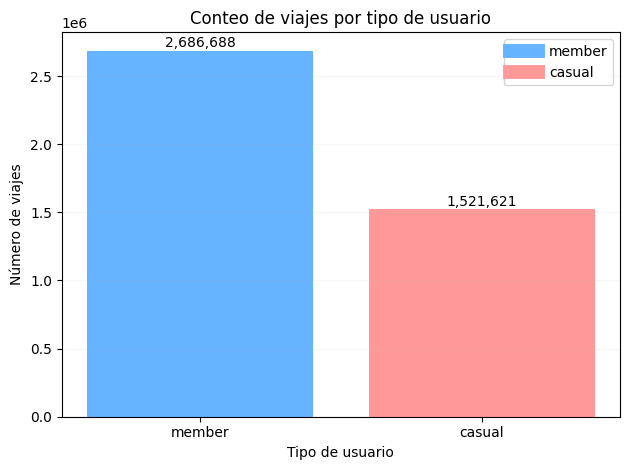

In [ ]:
# Conteo tipos de usuario:

conteo = df_total['member_casual'].value_counts()

colores = {'member': '#66b3ff', 'casual': '#ff9999'}
fig, ax = plt.subplots()
figsize=(8, 5)

barras = ax.bar(conteo.index, conteo.values, color=[colores[tipo] for tipo in conteo.index])

# Añadir etiquetas de número encima de cada barra:

for barra in barras:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, altura + 5000, 
            f'{int(altura):,}', ha='center', va='bottom')

# Añadir título y etiquetas:

ax.set_title('Conteo de viajes por tipo de usuario')
ax.set_xlabel('Tipo de usuario')
ax.set_ylabel('Número de viajes')
ax.grid(axis='y', alpha=0.1)

# Agregar leyenda personalizada:

leyendas = [plt.Line2D([0], [0], color=color, lw=10) for color in colores.values()]
ax.legend(leyendas, colores.keys())

plt.tight_layout()
plt.show()


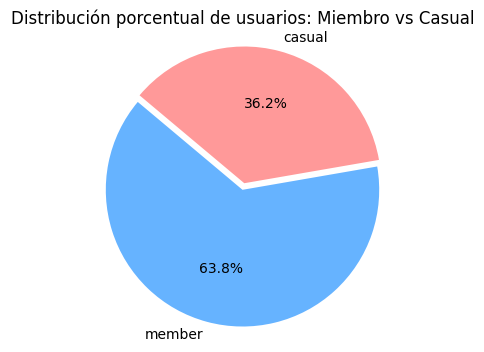

In [ ]:
# Gráfico de pastel miembro vs casual:

porcentaje = df_total['member_casual'].value_counts(normalize=True) * 100
porcentaje = porcentaje.round(2)

labels = porcentaje.index  
sizes = porcentaje.values  
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)

plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Distribución porcentual de usuarios: Miembro vs Casual')
plt.axis('equal')
plt.show()

Los datos muestran que el **63.8%** de los viajes durante 2024 fueron realizados por miembros de Cyclistic, en comparación con el **36.2%** por usuarios ocasionales, lo cual refleja una mayor fidelidad y frecuencia de uso en el segmento de miembros. Dentro de la participación en el total de viajes existe una diferencia absoluta de más de 1.1 millones de viajes entre ambos grupos, lo que respalda que los miembros son un grupo rentable y activo.

**¿Qué tipo de bicicleta prefiere cada usuario?**

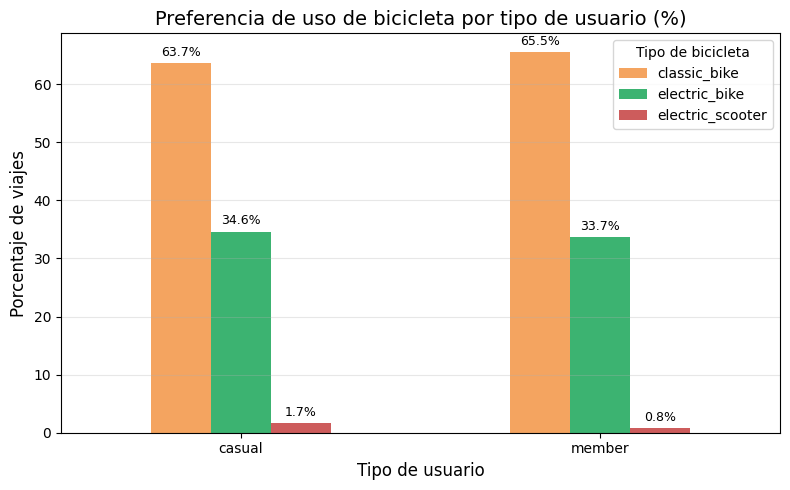

In [ ]:
# Porcentaje de uso de tipos de bicicleta dentro de cada tipo de usuario:

bike_user_percent = pd.crosstab(df_total['member_casual'], df_total['rideable_type'], normalize='index') * 100
bike_user_percent = bike_user_percent.round(2)

ax = bike_user_percent.plot(kind='bar', figsize=(8, 5), color=['#F4A460', '#3CB371', '#CD5C5C'])

plt.title('Preferencia de uso de bicicleta por tipo de usuario (%)', fontsize=14)
plt.xlabel('Tipo de usuario', fontsize=12)
plt.ylabel('Porcentaje de viajes', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Tipo de bicicleta', fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Etiquetas numéricas:

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9, padding=3)

plt.tight_layout()
plt.show()

El gráfico de barras agrupadas revela cómo fué el comportamiento entre usuarios y el uso de cada tipo de bicicleta. Teniendo presente que los porcentajes se toman bajo el 100%, el uso de bicicletas clásicas para miembros fué de **65.5%** y para casuales fué de **63.7%**, el comportamiento en bicicletas eléctricas también se encuentra similar, para miembros fué de **33.7%** y para casuales fué de **34.6%**. Por lo tanto, no hay diferencias significativas en la preferencia por tipo de bicicleta, tanto miembros como usuarios casuales optaron por utilizar bicicletas clásicas, seguidas de las eléctricas.


Respecto al uso de las patinetas eléctricas, este dato no presentó mayor volumen en su utilización ya que no superó el 1% del total. No obstante, es válido considerar que podría deberse a que son personas que no utilizan muy frecuentemente el servicio y estuvieron dispuestas a experimentar una alternativa no convencional.<br> 

La preferencia de uso de bicibleta por tipo de usuario, demostró que los patrones de comportamiento fueron similares, por lo tanto, las diferencias de comportamiento entre miembros y casuales no están determinadas por la preferencia del tipo de bicicleta. A continucación, 
se abordarán factores como la frecuencia de uso, el momento del día en que realizarón los viajes y las estaciones más utilizadas.

**¿Qué horario fue el más frecuentado respecto a los usuarios casuales y miembros?**

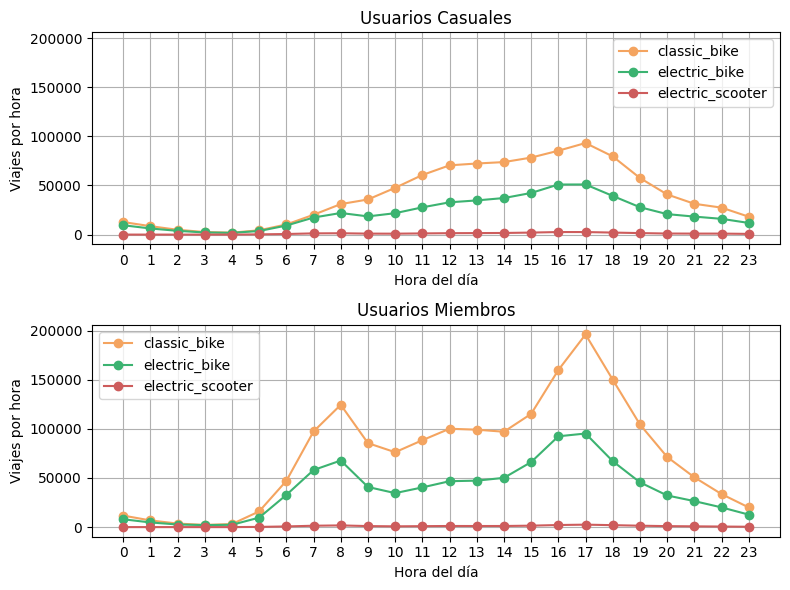

In [ ]:
# Utilizar la variable travel_hour:

df_total['travel_hour'] = df_total['started_at'].dt.hour

# Crear tabla de viajes por hora, tipo de usuario y tipo de bicicleta:

hora_usuario = df_total.groupby(['travel_hour', 'member_casual', 'rideable_type'])['ride_id'].count().unstack(fill_value=0)
hora_usuario = hora_usuario.sort_index()

# Crear dos gráficas lineales:

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=True)
colores = {'classic_bike': '#F4A460', 'electric_bike': '#3CB371', 'electric_scooter': '#CD5C5C'}

# Gráfico para usuarios casuales:

casual = hora_usuario.xs('casual', level=1)
for tipo in casual.columns:
    axes[0].plot(casual.index, casual[tipo], marker='o', label=tipo, color=colores.get(tipo, 'gray'))

axes[0].set_title('Usuarios Casuales')
axes[0].set_xlabel('Hora del día')
axes[0].set_ylabel('Viajes por hora')
axes[0].set_xticks(range(0, 24))
axes[0].legend()
axes[0].grid(True)

# Gráfico para usuarios miembros:

member = hora_usuario.xs('member', level=1)
for tipo in member.columns:
    axes[1].plot(member.index, member[tipo], marker='o', label=tipo, color=colores.get(tipo, 'gray'))

axes[1].set_title('Usuarios Miembros')
axes[1].set_xlabel('Hora del día')
axes[1].set_ylabel('Viajes por hora')
axes[1].set_xticks(range(0, 24))
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

En las dos gráficas, se visualiza como fue el servicio de préstamo por horas entre personas miembros y casuales durante el año 2024. Tanto miembros como usuarios casuales utilizaron mayoritariamente bicicletas clásicas, reafirmando la tendencia observada en análisis anteriores.

Para los miembros se observa dos picos marcados de uso: a las 8:00 h, posiblemente vinculado al inicio de la jornada laboral y a las 17:00 h,siendo esta distribución de uso rutinario, probablemente por parte de personas que utilizan el sistema como medio de transporte a sus lugares de empleo. En contraste, el comportamiento de uso en los usuarios casuales comenzó a aumentar desde las 7:00 h, alcanzando su punto máximo a las 17:00 h, con una demanda que se mantiene elevada durante algunas horas más, esto indica un patrón más extendido y flexible, característico de personas que posiblemente usan el servicio por recreación o actividades no relacionadas con el tema laboral. Los scooters eléctricos, aunque disponibles, tuvieron un uso mínimo en ambos grupos, por lo que su impacto en la dinámica diaria del sistema es irrelevante para la pregunta de negocio que se pretende responder.

La diferencia en los horarios de uso revela una segmentación de comportamiento entre los usuarios de Cyclistic, con base en esta información, futuras campañas podrían orientarse a cubrir mejor las necesidades de transporte en horas pico para miembros, mientras que para usuarios casuales, podrían desarrollarse estrategias enfocadas en el ocio, turismo y los fines de semana.



**¿Cuáles son las estaciones de inicio y fin más utilizadas?**

In [ ]:
# Contar cuántas veces se usa cada estación de inicio por tipo de usuario:

count_start = df_total.groupby(['start_station_name', 'member_casual']).size()

# Convertir cada tipo de usuario en una columna:

count_start = count_start.unstack(fill_value=0)

# Renombrar las columnas:

count_start = count_start.rename(columns={
    'member': 'count_miembro',
    'casual': 'count_casual'
})

# Índice station_name en columna:

count_start = count_start.reset_index()

# Crear columna con el total de viajes:

count_start['total'] = count_start['count_miembro'] + count_start['count_casual']

# Ordenar descendente el total de viajes:

count_start = count_start.sort_values('total', ascending=False)

# Seleccionar las 20 estaciones más usadas:

top_20_start = count_start[['start_station_name', 'count_miembro', 'count_casual']].head(20)
top_20_start.index = range(1,21)

print("- Las 20 estaciones de inicio más utilizadas por miembro y casual")
print(top_20_start)


- Las 20 estaciones de inicio más utilizadas por miembro y casual
member_casual                  start_station_name  count_miembro  count_casual
1                         Streeter Dr & Grand Ave          13962         48316
2               DuSable Lake Shore Dr & Monroe St           9295         32199
3              DuSable Lake Shore Dr & North Blvd          15303         21360
4                           Michigan Ave & Oak St          13015         23296
5                        Kingsbury St & Kinzie St          26807          9035
6                               Clark St & Elm St          22404          9621
7                    Clinton St & Washington Blvd          25167          6046
8                                 Millennium Park           9703         20841
9                         Clinton St & Madison St          22644          7218
10                          Wells St & Concord Ln          18131          9867
11                            Theater on the Lake          11995 

In [ ]:
# Contar cuántas veces se usa cada estación de fin por tipo de usuario:

count_end = df_total.groupby(['end_station_name', 'member_casual']).size()

# Convertir cada tipo de usuario en una columna:

count_end = count_end.unstack(fill_value=0)

# Renombrar las columnas:

count_end = count_end.rename(columns={
    'member': 'count_miembro',
    'casual': 'count_casual'
})

# Índice station_name en columna:

count_end = count_end.reset_index()

# Crear columna con el total de viajes:

count_end['Total'] = count_end['count_miembro'] + count_end['count_casual']

# Ordenar descendente el total de viajes:

count_end = count_end.sort_values('Total', ascending=False)

# Seleccionar las 20 estaciones más usadas:

top_20_end = count_end[['end_station_name', 'count_miembro', 'count_casual']].head(20)
top_20_end.index = range(1,21)

print("- Las 20 estaciones de fin más utilizadas por miembro y casual")
print(top_20_end)
                            

- Las 20 estaciones de fin más utilizadas por miembro y casual
member_casual                    end_station_name  count_miembro  count_casual
1                         Streeter Dr & Grand Ave          11433         52436
2              DuSable Lake Shore Dr & North Blvd          15111         25130
3               DuSable Lake Shore Dr & Monroe St          10092         30120
4                           Michigan Ave & Oak St          12359         24188
5                        Kingsbury St & Kinzie St          26925          8516
6                    Clinton St & Washington Blvd          25542          5863
7                               Clark St & Elm St          22208          9125
8                                 Millennium Park           8240         22913
9                         Clinton St & Madison St          23389          6889
10                          Wells St & Concord Ln          18294         10091
11                            Theater on the Lake          11422    

En el procedimiento anterior, se extrajo del DataFrame general los datos de la variable *start_station_name*, *end_station_name*, y la variable *member_casual* se dividió con el propósito de visualizar cuantos viajes se encuentran registrados por personas miembros y casuales, para tener una visión global sobre las veinte estaciones más utilizadas como inicio y fin de viaje.<br>

En el caso de los usuarios miembros, las estaciones más frecuentadas parecen ubicarse en zonas con una alta concentración de oficinas y centros de trabajo, lo cual coincide con los picos de horario laboral mencionados anteriormente. Por otro lado, las personas usuarias ocasionales iniciaron y finalizaron sus viajes en estaciones próximas a sitios culturales, zonas turísticas y de esparcimiento, como Millennium Park, Shedd Aquarium o DuSable Lake Shore Drive.<br>   

Con el objetivo de asociar los patrones identificados a ubicaciones reales, se utilizarán las coordenadas geográficas latitud y longitud presentes en la base de datos, se obtendrá el mapa de la ciudad de Chicago por medio de la librería GeoPandas, lo que permitirá visualizar de manera precisa la distribución espacial de las estaciones más utilizadas según el tipo de usuario. Esta visualización geográfica será clave para identificar zonas de alta demanda y plantear estrategias de marketing focalizadas.

In [ ]:
# Contar cuántas veces se usó cada estación de inicio por tipo de usuario:

count_start = df_total.groupby(['start_station_name', 'member_casual']).size()

# Convertir cada tipo de usuario en una columna:

count_start = count_start.unstack(fill_value=0)

# Renombrar las columnas:

count_start = count_start.rename(columns={
    'member': 'count_miembro',
    'casual': 'count_casual'
})

# Pasar el índice a una columna:

count_start = count_start.reset_index()

# Crear columna con el total de viajes:

count_start['Total'] = count_start['count_miembro'] + count_start['count_casual']

# Ordenar por total de viajes:

count_start = count_start.sort_values('Total', ascending=False)

# Seleccionar las 20 estaciones más usadas:

top_20_start = count_start.head(20)

# Obtener una única coordenada por estación:

start_coords_unique = (
    df_total
    .groupby('start_station_name')[['start_lat', 'start_lng']]
    .first()
    .reset_index()
)

# Unir coordenadas únicas con top_20_end:

top_20_start = top_20_start.merge(start_coords_unique, on='start_station_name', how='left')

# Seleccionar columnas finales:

top_20_start = top_20_start[['start_station_name', 'count_miembro', 'count_casual', 'start_lat', 'start_lng']]
top_20_start.index = range(1, 21)

print("- Las 20 estaciones de inicio más utilizadas por miembro y casual, con una sola coordenada única por estación")
print(top_20_start)

- Las 20 estaciones de inicio más utilizadas por miembro y casual, con una sola coordenada única por estación
                    start_station_name  count_miembro  count_casual  \
1              Streeter Dr & Grand Ave          13962         48316   
2    DuSable Lake Shore Dr & Monroe St           9295         32199   
3   DuSable Lake Shore Dr & North Blvd          15303         21360   
4                Michigan Ave & Oak St          13015         23296   
5             Kingsbury St & Kinzie St          26807          9035   
6                    Clark St & Elm St          22404          9621   
7         Clinton St & Washington Blvd          25167          6046   
8                      Millennium Park           9703         20841   
9              Clinton St & Madison St          22644          7218   
10               Wells St & Concord Ln          18131          9867   
11                 Theater on the Lake          11995         15398   
12                   Wells St & Elm St

In [ ]:
# Contar cuántas veces se usa cada estación de fin por tipo de usuario:

count_end = df_total.groupby(['end_station_name', 'member_casual']).size()

# Convertir cada tipo de usuario en una columna:

count_end = count_end.unstack(fill_value=0)

# Renombrar las columnas:

count_end = count_end.rename(columns={
    'member': 'count_miembro',
    'casual': 'count_casual'
})

# Pasar el índice a una columna:

count_end = count_end.reset_index()

# Crear columna con el total de viajes:

count_end['Total'] = count_end['count_miembro'] + count_end['count_casual']

# Ordenar por total de viajes:

count_end = count_end.sort_values('Total', ascending=False)

# Seleccionar las 20 estaciones más usadas:

top_20_end = count_end.head(20)

# Obtener una única coordenada por estación
end_coords_unique = (
    df_total
    .groupby('end_station_name')[['end_lat', 'end_lng']]
    .first()
    .reset_index()
)

# Unir coordenadas únicas con top_20_end:

top_20_end = top_20_end.merge(end_coords_unique, on='end_station_name', how='left')

# Seleccionar columnas finales:

top_20_end = top_20_end[['end_station_name', 'count_miembro', 'count_casual', 'end_lat', 'end_lng']]
top_20_end.index = range(1, 21)

print("- Las 20 estaciones de fin más utilizadas por miembro y casual, con una sola coordenada única por estación")
print(top_20_end)

- Las 20 estaciones de fin más utilizadas por miembro y casual, con una sola coordenada única por estación
                      end_station_name  count_miembro  count_casual  \
1              Streeter Dr & Grand Ave          11433         52436   
2   DuSable Lake Shore Dr & North Blvd          15111         25130   
3    DuSable Lake Shore Dr & Monroe St          10092         30120   
4                Michigan Ave & Oak St          12359         24188   
5             Kingsbury St & Kinzie St          26925          8516   
6         Clinton St & Washington Blvd          25542          5863   
7                    Clark St & Elm St          22208          9125   
8                      Millennium Park           8240         22913   
9              Clinton St & Madison St          23389          6889   
10               Wells St & Concord Ln          18294         10091   
11                 Theater on the Lake          11422         16906   
12                   Wells St & Elm St   

In [ ]:
# Crear tabla con información de miembros:

member_start = top_20_start[['start_station_name', 'count_miembro', 'start_lat', 'start_lng']]
print("- Tabla de miembros:")
print(member_start)

# Crear tabla con información de usuarios casuales:

casual_start = top_20_start[['start_station_name', 'count_casual', 'start_lat', 'start_lng']]
print("- Tabla de usuarios casuales:")
print(casual_start)

- Tabla de miembros:
                    start_station_name  count_miembro  start_lat  start_lng
1              Streeter Dr & Grand Ave          13962  41.892262 -87.611957
2    DuSable Lake Shore Dr & Monroe St           9295  41.880958 -87.616743
3   DuSable Lake Shore Dr & North Blvd          15303  41.911725 -87.626765
4                Michigan Ave & Oak St          13015  41.901172 -87.623334
5             Kingsbury St & Kinzie St          26807  41.889199 -87.638480
6                    Clark St & Elm St          22404  41.902695 -87.631662
7         Clinton St & Washington Blvd          25167  41.883115 -87.641382
8                      Millennium Park           9703  41.881227 -87.623984
9              Clinton St & Madison St          22644  41.882752 -87.641190
10               Wells St & Concord Ln          18131  41.912133 -87.634656
11                 Theater on the Lake          11995  41.926266 -87.631033
12                   Wells St & Elm St          17936  41.903267 -8

In [ ]:
# Crear tabla con información de miembros:

member_end = top_20_end[['end_station_name', 'count_miembro', 'end_lat', 'end_lng']]
print("- Tabla de miembros:")
print(member_end)

# Crear tabla con información de usuarios casuales:

casual_end = top_20_end[['end_station_name', 'count_casual', 'end_lat', 'end_lng']]
print("- Tabla de usuarios casuales:")
print(casual_end)

- Tabla de miembros:
                      end_station_name  count_miembro    end_lat    end_lng
1              Streeter Dr & Grand Ave          11433  41.892278 -87.612043
2   DuSable Lake Shore Dr & North Blvd          15111  41.911722 -87.626804
3    DuSable Lake Shore Dr & Monroe St          10092  41.880958 -87.616743
4                Michigan Ave & Oak St          12359  41.900960 -87.623777
5             Kingsbury St & Kinzie St          26925  41.889177 -87.638506
6         Clinton St & Washington Blvd          25542  41.883380 -87.641170
7                    Clark St & Elm St          22208  41.902973 -87.631280
8                      Millennium Park           8240  41.881032 -87.624084
9              Clinton St & Madison St          23389  41.882752 -87.641190
10               Wells St & Concord Ln          18294  41.912133 -87.634656
11                 Theater on the Lake          11422  41.926277 -87.630834
12                   Wells St & Elm St          17945  41.903222 -8

In [ ]:
# Crear tabla con información de miembros de inicio:

member_start = top_20_start[['start_station_name', 'count_miembro', 'start_lat', 'start_lng']]

# Crear tabla con información de usuarios casuales de inicio:

casual_start = top_20_start[['start_station_name', 'count_casual', 'start_lat', 'start_lng']]

print(member_start)
print(casual_start)

                    start_station_name  count_miembro  start_lat  start_lng
1              Streeter Dr & Grand Ave          13962  41.892262 -87.611957
2    DuSable Lake Shore Dr & Monroe St           9295  41.880958 -87.616743
3   DuSable Lake Shore Dr & North Blvd          15303  41.911725 -87.626765
4                Michigan Ave & Oak St          13015  41.901172 -87.623334
5             Kingsbury St & Kinzie St          26807  41.889199 -87.638480
6                    Clark St & Elm St          22404  41.902695 -87.631662
7         Clinton St & Washington Blvd          25167  41.883115 -87.641382
8                      Millennium Park           9703  41.881227 -87.623984
9              Clinton St & Madison St          22644  41.882752 -87.641190
10               Wells St & Concord Ln          18131  41.912133 -87.634656
11                 Theater on the Lake          11995  41.926266 -87.631033
12                   Wells St & Elm St          17936  41.903267 -87.634737
13          

In [ ]:
# Crear tabla con información de miembros de fin:

member_end = top_20_end[['end_station_name', 'count_miembro', 'end_lat', 'end_lng']]

# Crear tabla con información de usuarios casuales de fin: 

casual_end = top_20_end[['end_station_name', 'count_casual', 'end_lat', 'end_lng']]

print(member_end)
print(casual_end)

                      end_station_name  count_miembro    end_lat    end_lng
1              Streeter Dr & Grand Ave          11433  41.892278 -87.612043
2   DuSable Lake Shore Dr & North Blvd          15111  41.911722 -87.626804
3    DuSable Lake Shore Dr & Monroe St          10092  41.880958 -87.616743
4                Michigan Ave & Oak St          12359  41.900960 -87.623777
5             Kingsbury St & Kinzie St          26925  41.889177 -87.638506
6         Clinton St & Washington Blvd          25542  41.883380 -87.641170
7                    Clark St & Elm St          22208  41.902973 -87.631280
8                      Millennium Park           8240  41.881032 -87.624084
9              Clinton St & Madison St          23389  41.882752 -87.641190
10               Wells St & Concord Ln          18294  41.912133 -87.634656
11                 Theater on the Lake          11422  41.926277 -87.630834
12                   Wells St & Elm St          17945  41.903222 -87.634324
13          

In [ ]:
# Generar Data Frame con GeoPandas para las estaciones de inicio:

gdf_start_member = gpd.GeoDataFrame(
    member_start, geometry=gpd.points_from_xy(member_start["start_lng"], member_start["start_lat"]), crs="EPSG:4326")

gdf_end_member = gpd.GeoDataFrame(
    member_end, geometry=gpd.points_from_xy(member_end["end_lng"], member_end["end_lat"]), crs="EPSG:4326")

# Crear un mapa centrado en Chicago:

m = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Añadir estaciones de inicio (azul):

for idx, row in gdf_start_member.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["start_station_name"],
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# Añadir estaciones de fin (rojo):

for idx, row in gdf_end_member.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["end_station_name"],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# Guardar el mapa en un archivo HTML:

m.save("map_chicago_member.html")

In [ ]:
# Generar Data Frame con GeoPandas para las estaciones de fin:

gdf_end_casual = gpd.GeoDataFrame(
    casual_end, geometry=gpd.points_from_xy(casual_end["end_lng"], casual_end["end_lat"]), crs="EPSG:4326")

gdf_end_casual = gpd.GeoDataFrame(
    casual_end, geometry=gpd.points_from_xy(casual_end["end_lng"], casual_end["end_lat"]), crs="EPSG:4326")

# Crear un mapa centrado en Chicago:

m = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Añadir estaciones de inicio (azul):

for idx, row in gdf_end_casual.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["end_station_name"],
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# Añadir estaciones de fin (rojo):

for idx, row in gdf_end_casual.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row["end_station_name"],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# Guardar el mapa en un archivo HTML:

m.save("map_chicago_casual.html")

En los anteriores datos geográficos realizados con GeoPandas, es posible visualizar las veinte estaciones de inicio y fin más utilizadas entre socios anuales y ocasionales. Si la estación aparece como inicio y fin de viaje se identificó con el color morado, para estaciones que solo se encuentran como inicio, se utilizó el color azul y para estaciones que solo se encuentran como fin, el color rojo.<br>

Al explorar ambos mapas y analizar su comportamiento, se evidenció una alta coincidencia en las estaciones más utilizadas, las ubicaciones más frecuentes incluyen estaciones próximas a estaciones de tren, complejos deportivos, parques, museos, clubes deportivos, asociaciones médicas, el puerto marítimo y el campus universitario de Chicago. No obstante, se identificaron diferencias notables:<br>

Las personas casuales registraron mayor actividad durante las horas de la tarde, entre las estaciones utilizadas por este grupo se encuentran cafés, establecimientos de alimentos y bibliotecas, siendo actividades de uso recreativo, sociales o turísticas. En contraste, los miembros anuales muestran picos de uso en la mañana y en la tarde, las estaciones más frecuentadas se ubican en cercanía a edificios administrativos y zonas empresariales, lo cual concuerda con una rutina laboral.<br>

De acuerdo con el objetivo de negocio y la posibilidad de maximizar el número de miembros anuales, una posibilidad sería focalizar publicidad sobre membresías en puntos estratégicos que fueron más visitados por personas casuales ya que las probabilidades de generar suscripciones sería mayor. Finalmente, es válido considerar llevar campañas de marketing a sitios de alta afluencia de mayor concurrencia en la ciudad como centros administrativos, parques y sitios culturales para generar un posicionamiento de marca dentro de la ciudad, fortalecer la marca Cyclistic como una alternativa de transporte confiable para realizar diversos tipos de desplazamientos, sumado con un servicio e infraestructura adecuada, asegura su éxito. 